# k-Nearest Neighbours

In [1]:
import sys
sys.path.append("./git/")

KNN is the simplest, easiest, most basic kind of predictive model there is.

It relies on two things:
- some measure of distance
- an assumption that data points that are close to one another are similar.

Whereas most other techniques look at and made predictions based on the whole dataset, KNN disregards most of the data points and instead focuses on only a handful of data points (k).

Let's say we've picked k to be 3 or 5.

If we want to classify some new data point, we find the k nearest labeled points and let them vote on the new input.

To do this, let's define a function that counts votes. One possibility is:

In [2]:
from typing import List
from collections import Counter

def raw_majority_vote(labels: List[str]) -> str:
    votes = Counter(labels)
    winner, _ = votes.most_common(1)[0]
    return winner

assert raw_majority_vote(['a','b','c','b']) == 'b'

But what if its a tie?

In this case we can do a few things. Let's go with reducing k by one and picking the winner of the (k-1) nearest neighbours.

In [3]:
def majority_vote(labels: List[str]) -> str:
    """Assumes labels are ordered from nearest to farthest"""
    vote_counts = Counter(labels)
    winner, winner_count = vote_counts.most_common(1)[0]
    num_winners = len([count 
                       for count in vote_counts.values() 
                       if count == winner_count])
    if num_winners == 1:
        return winner
    else:
        return majority_vote(labels[:-1])
    
assert majority_vote(list('abcba')) == 'b'

In [4]:
from typing import NamedTuple
from scratch.linear_algebra import Vector, distance

class LabeledPoint(NamedTuple):
    point: Vector
    label: str
def knn_classify(k: int, 
                 labeled_points: List[LabeledPoint],
                 new_point: Vector) -> str:
    by_distance = sorted(labeled_points,
                         key=lambda lp: distance(lp.point,new_point))

    k_nearest_labels = [lp.label for lp in by_distance[:k]]

    return majority_vote(k_nearest_labels)

## Example: iris dataset

In [5]:
import requests

data = requests.get("https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data")

with open('iris.dat','w') as f:
    f.write(data.text)

In [40]:
from typing import Dict
import csv
from collections import defaultdict

with open('iris.dat') as f:
    reader = csv.reader(f)
    data = [line for line in reader]
    data = data[:-1]
    
measurements = [list(map(float,row[:-1])) for row in data]
species = [row[-1].split("-")[-1] for row in data]

assert len(measurements) == len(species), "Length mismatch"

points_by_species: Dict[str, List[Vector]] = defaultdict(list)
for n,specie in enumerate(species):
    points_by_species[specie].append(measurements[n])

species_lengths = []
for specie in points_by_species:
    species_lengths.append(len(points_by_species[specie]))
    
assert all(x == species_lengths[0] for x in species_lengths)

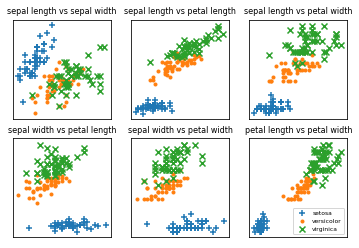

In [42]:
import matplotlib.pyplot as plt
metrics = "sepal length,sepal width,petal length,petal width".split(",")
pairs = [(i,j) for i in range(4) for j in range(4) if i < j]
marks = ['+','.','x']
fig, ax = plt.subplots(2,3)

for row in range(2):
    for col in range(3):
        i, j = pairs[3 * row + col]
        ax[row][col].set_title(f"{metrics[i]} vs {metrics[j]}", fontsize=8)
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([])

        for mark, (species, points) in zip(marks, points_by_species.items()):
            xs = [point[i] for point in points]
            ys = [point[j] for point in points]
            ax[row][col].scatter(xs, ys, marker=mark, label=species)

ax[-1][-1].legend(loc='lower right', prop={'size': 6})
plt.show()

In [44]:
import random
from scratch.machine_learning import split_data

random.seed(12)

iris_train,iris_test = split_data(data,0.70)
assert len(iris_train) == 0.7 * 150
assert len(iris_test) == 0.3 * 150

In [48]:
iris_test

[['5.0', '3.5', '1.3', '0.3', 'Iris-setosa'],
 ['5.6', '2.5', '3.9', '1.1', 'Iris-versicolor'],
 ['5.1', '3.5', '1.4', '0.3', 'Iris-setosa'],
 ['6.5', '3.0', '5.2', '2.0', 'Iris-virginica'],
 ['6.5', '3.0', '5.5', '1.8', 'Iris-virginica'],
 ['5.8', '4.0', '1.2', '0.2', 'Iris-setosa'],
 ['6.3', '3.3', '4.7', '1.6', 'Iris-versicolor'],
 ['6.5', '2.8', '4.6', '1.5', 'Iris-versicolor'],
 ['7.7', '2.8', '6.7', '2.0', 'Iris-virginica'],
 ['5.2', '3.4', '1.4', '0.2', 'Iris-setosa'],
 ['6.7', '3.1', '4.4', '1.4', 'Iris-versicolor'],
 ['5.4', '3.0', '4.5', '1.5', 'Iris-versicolor'],
 ['6.9', '3.2', '5.7', '2.3', 'Iris-virginica'],
 ['6.5', '3.0', '5.8', '2.2', 'Iris-virginica'],
 ['5.0', '3.4', '1.5', '0.2', 'Iris-setosa'],
 ['6.9', '3.1', '5.4', '2.1', 'Iris-virginica'],
 ['6.8', '3.2', '5.9', '2.3', 'Iris-virginica'],
 ['4.8', '3.4', '1.6', '0.2', 'Iris-setosa'],
 ['7.3', '2.9', '6.3', '1.8', 'Iris-virginica'],
 ['7.1', '3.0', '5.9', '2.1', 'Iris-virginica'],
 ['7.2', '3.0', '5.8', '1.6', 'Ir

In [50]:
from typing import Tuple

confusion_matrix: Dict[Tuple[str,str],int] = defaultdict(int)
num_correct = 0

for iris in iris_test:
    predicted = knn_classify(5,iris_train,iris[:-1])
    actual = iris.label
    
    if predicted == actual:
        num_correct += 1
        
    confusion_matrix[(predicted,actual)] += 1
    
pct_correct = num_correct / len(iris_test)
print(pct_correct, confusion_matrix)

AttributeError: 'list' object has no attribute 'point'

# The Curse of Dimensionality

Points in higher dimensional spaces are rarely close together. In fact, they tend to be vast distances apart.

Let's illustrate this by example:

In [51]:
def random_point(dim: int) -> Vector:
    return [random.random() for _ in range(dim)]

def random_distances(dim: int, num_pairs: int) -> List[float]:
    return [distance(random_point(dim),random_point(dim)) 
            for _ in range(num_pairs)]

For every dimension from 1 to 100 we'll calculate 10,000 distances and use those to compute the average distance between points and the minimum distance between points in each dimension.

In [54]:
import tqdm

dimensions = range(1,101)

avg_d = []
min_d = []

random.seed(0)
for dim in tqdm.tqdm(dimensions, desc = 'Curse of Dimensionality'):
    distances = random_distances(dim,10000)
    avg_d.append(sum(distances) / 10000)
    min_d.append(min(distances))

Curse of Dimensionality: 100%|███████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.87it/s]


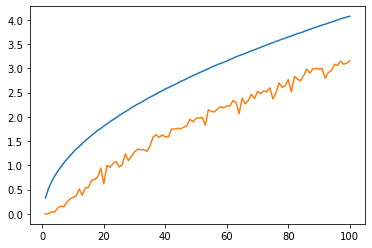

In [55]:
plt.plot(dimensions,avg_d)
plt.plot(dimensions,min_d)
plt.show()

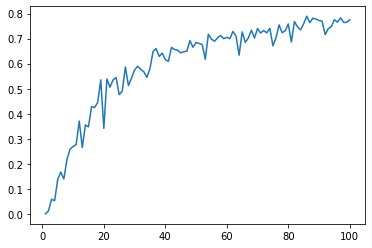

In [57]:
min_to_avg = [minimum / average 
              for minimum, average 
              in zip(min_d,avg_d)]

plt.plot(dimensions,min_to_avg)
plt.show()

In low-dimensional datasets the minimum tends to be close to the average.

Any two points can only be close if they are close in *every*  dimension. As the dimensionality of the data increases, the likelihood that this is true drops dramatically.

Therefore, in high d-space the minimum distance between points is likely to be closer to the average distance between points, which means...

**... KNN becomes less and less effective in higher dimensional spaces.**